In [1]:
# !unzip /Faces.zip

In [2]:
import os
from tqdm import tqdm
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import pandas as pd
from sklearn.decomposition import PCA
from skimage import feature

from tqdm import tqdm
from sklearn.feature_extraction.image import PatchExtractor
from itertools import chain
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [3]:
from utils import create_images_list

# Preparación de los datos

In [4]:
import importlib
import constants
importlib.reload(constants)
from constants import (BACKGROUND_PATH)

In [5]:
facesPath = 'Faces' # use '/content/Faces' on colab
faces = create_images_list([facesPath])
faces.shape


100%|██████████| 12833/12833 [00:02<00:00, 5877.55it/s]


(12833, 64, 64)

In [6]:
fondos = create_images_list([BACKGROUND_PATH])
fondos.shape


100%|██████████| 12800/12800 [00:03<00:00, 3757.19it/s]


(12800, 64, 64)

In [7]:
images = list(faces) + list(fondos)

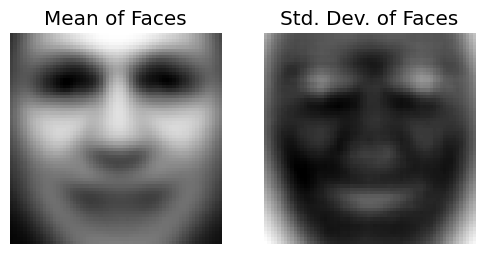

In [8]:
# Calculamos la imagen promedio y la desviación estándar para cada dígito
mean_images = np.mean(images, axis=0)
std_images = np.std(images, axis=0)

# Visualizamos las imágenes promedio y las desviaciones estándar
fig, axs = plt.subplots(1, 2, figsize=(6, 6))

axs[0].imshow(mean_images, cmap='gray')
axs[0].set_title(f"Mean of Faces")
axs[0].axis('off')

axs[1].imshow(std_images, cmap='gray')
axs[1].set_title(f"Std. Dev. of Faces")
axs[1].axis('off')

plt.show()

In [9]:
X = np.array([feature.hog(im) for im in tqdm(chain(faces, fondos), desc='Construyendo X')])
y = np.zeros(len(X))
faces_len = len(faces)
y[:faces_len]= 1

Construyendo X: 25633it [00:14, 1784.91it/s]


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
X_train_std = StandardScaler().fit_transform(X_train)

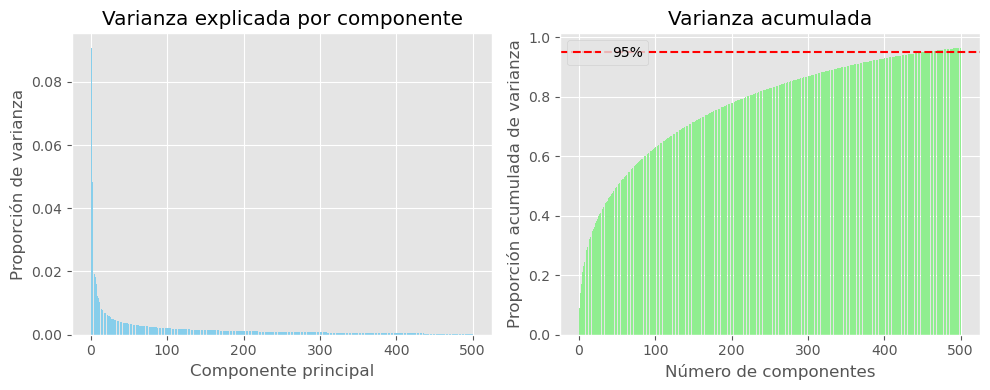

In [12]:
# Apply PCA to extract eigenfaces
pca = PCA(n_components=500, whiten=False).fit(X_train_std)

# Obtener varianzas
var_explicada = pca.explained_variance_ratio_
var_acumulada = np.cumsum(var_explicada)

# Gráfico
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Varianza explicada
ax1.bar(range(1, len(var_explicada)+1), var_explicada, color='skyblue')
ax1.set_title('Varianza explicada por componente')
ax1.set_xlabel('Componente principal')
ax1.set_ylabel('Proporción de varianza')
ax1.grid(True)

# Varianza acumulada
ax2.bar(range(1, len(var_acumulada)+1), var_acumulada, color='lightgreen')
ax2.axhline(y=0.95, color='r', linestyle='--', label='95%')
ax2.set_title('Varianza acumulada')
ax2.set_xlabel('Número de componentes')
ax2.set_ylabel('Proporción acumulada de varianza')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

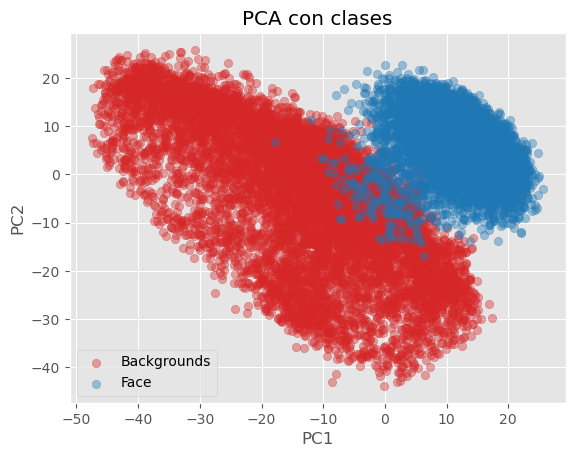

In [13]:
X_train_pca = pca.transform(X_train_std)

# Graficar con colores y leyenda
colors = ['tab:red', 'tab:blue']
labels = ['Backgrounds', 'Face']

for class_value in [0, 1]:
    plt.scatter(
        X_train_pca[y_train == class_value, 0],
        X_train_pca[y_train == class_value, 1],
        c=colors[class_value],
        label=labels[class_value],
        alpha=0.4
    )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA con clases')
plt.legend()
plt.grid(True)
plt.show()

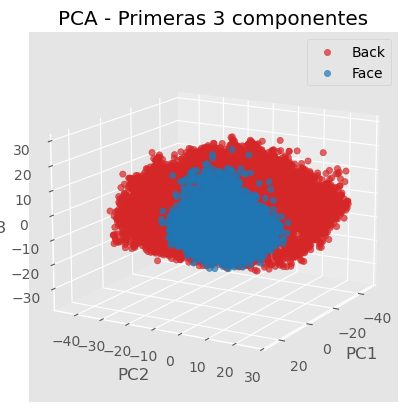

In [14]:
# Plot 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = ['tab:red', 'tab:blue']
labels = ['Back', 'Face']

for class_value in [0, 1]:
    ax.scatter(
        X_train_pca[y_train == class_value, 0],
        X_train_pca[y_train == class_value, 1],
        X_train_pca[y_train == class_value, 2],
        c=colors[class_value],
        label=labels[class_value],
        alpha=0.7
    )

ax.view_init(elev=15, azim=30)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('PCA - Primeras 3 componentes')
ax.legend()
plt.show()


In [18]:
# Clasificador
model = GaussianNB()

model.fit(X_train_pca, y_train)

y_train_pred = model.predict(X_train_pca)
print(classification_report(y_train, y_train_pred))

# Estandarizar y transformar datos de test
scaler = StandardScaler()
X_test_std = scaler.fit_transform(X_test)
X_test_pca = pca.transform(X_test_std)

y_test_pred = model.predict(X_test_pca)

print(f"y_test shape: {y_test.shape}")
print(f"y_test_pred shape: {y_test_pred.shape}")
print(classification_report(y_test, y_test_pred))


              precision    recall  f1-score   support

         0.0       0.94      0.97      0.96     10273
         1.0       0.97      0.94      0.95     10233

    accuracy                           0.96     20506
   macro avg       0.96      0.96      0.96     20506
weighted avg       0.96      0.96      0.96     20506

y_test shape: (5127,)
y_test_pred shape: (5127,)
              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96      2527
         1.0       0.97      0.94      0.96      2600

    accuracy                           0.96      5127
   macro avg       0.96      0.96      0.96      5127
weighted avg       0.96      0.96      0.96      5127



In [19]:
from sklearn.svm import SVC

model = SVC(kernel='rbf', probability=True)
model.fit(X_train_pca, y_train)


y_train_pred = model.predict(X_train_pca)
print(classification_report(y_train, y_train_pred))

# Estandarizar y transformar datos de test
scaler = StandardScaler()
X_test_std = scaler.fit_transform(X_test)
X_test_pca = pca.transform(X_test_std)

y_test_pred = model.predict(X_test_pca)

print(f"y_test shape: {y_test.shape}")
print(f"y_test_pred shape: {y_test_pred.shape}")
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10273
         1.0       1.00      1.00      1.00     10233

    accuracy                           1.00     20506
   macro avg       1.00      1.00      1.00     20506
weighted avg       1.00      1.00      1.00     20506

y_test shape: (5127,)
y_test_pred shape: (5127,)
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2527
         1.0       1.00      1.00      1.00      2600

    accuracy                           1.00      5127
   macro avg       1.00      1.00      1.00      5127
weighted avg       1.00      1.00      1.00      5127



In [20]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_pca, y_train)

y_train_pred = model.predict(X_train_pca)
print(classification_report(y_train, y_train_pred))

# Estandarizar y transformar datos de test
scaler = StandardScaler()
X_test_std = scaler.fit_transform(X_test)
X_test_pca = pca.transform(X_test_std)

y_test_pred = model.predict(X_test_pca)

print(f"y_test shape: {y_test.shape}")
print(f"y_test_pred shape: {y_test_pred.shape}")
print(classification_report(y_test, y_test_pred))




              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10273
         1.0       1.00      1.00      1.00     10233

    accuracy                           1.00     20506
   macro avg       1.00      1.00      1.00     20506
weighted avg       1.00      1.00      1.00     20506

y_test shape: (5127,)
y_test_pred shape: (5127,)
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      2527
         1.0       1.00      0.97      0.98      2600

    accuracy                           0.98      5127
   macro avg       0.99      0.98      0.98      5127
weighted avg       0.99      0.98      0.98      5127



# Reconstrucción

In [16]:
idx = 2050  # Índice de la imagen a reconstruir
original = X[idx]
pc_scores = X_train_pca[idx]
pc_scores


array([-2.56487020e+01,  2.77372091e+00,  7.00698359e+00, -2.09912797e+01,
       -1.81436219e+00, -9.33419619e-02,  4.96239497e+00, -8.19316299e+00,
       -9.89676734e+00, -4.58235394e+00,  8.36330812e-01, -5.90262294e+00,
        1.73765020e-01, -4.29579847e+00, -5.10160702e-01,  7.04586109e+00,
        4.33963658e+00,  5.96893056e+00,  4.60290289e+00, -3.32722794e+00,
        6.51661079e+00, -7.21996925e+00, -4.87746164e+00,  1.87371339e+00,
        4.19122820e+00,  1.01792670e+01, -4.35413963e-01,  7.99802721e+00,
       -1.95664385e+00,  7.74437479e+00,  2.94735787e+00, -9.09058835e+00,
        8.02216422e-01, -3.79392053e-01, -1.85733801e+00, -2.80871089e+00,
       -3.60315400e-01,  1.00135479e+00, -4.24007221e+00,  4.19115461e-01,
       -4.32531905e+00, -1.69309169e+00,  7.22662323e-01, -2.41011187e+00,
       -7.96294306e+00,  3.66774510e+00, -3.79236812e+00, -5.96836986e+00,
       -5.05553937e-01, -4.26917891e-01, -5.91205885e+00,  1.78225136e+00,
        9.42525878e-01,  

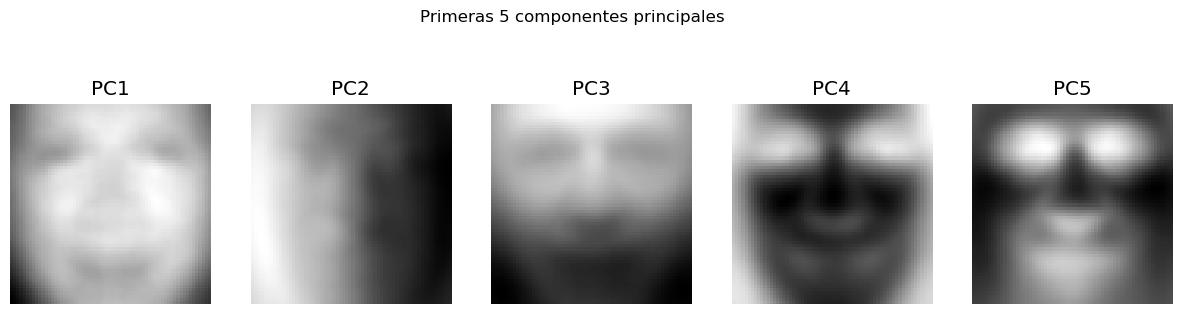

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(15, 4))
for i, ax in enumerate(axes):
    ax.imshow(pca.components_[i].reshape(64, 64), cmap='gray')
    ax.set_title(f'PC{i+1}')
    ax.axis('off')
plt.suptitle('Primeras 5 componentes principales')
plt.show()

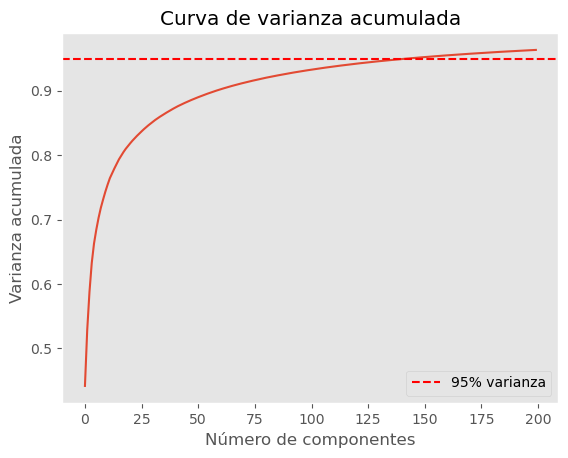

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y=0.95, color='r', linestyle='--', label='95% varianza')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza acumulada')
plt.title('Curva de varianza acumulada')
plt.legend()
plt.grid()
plt.show()